In [3]:
import os
from scipy.io import wavfile
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from cfg import Config
from sklearn.utils.class_weight import compute_class_weight as sklearn_compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from python_speech_features import mfcc

## Model 1 : Convolutional neural network


In [4]:
def get_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

## Model 2 : Recurrent neural network (LSTM)

In [5]:
def get_recurrent_model(input_shape) :
    #Shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['acc'])
    return model

## Model Preparation 

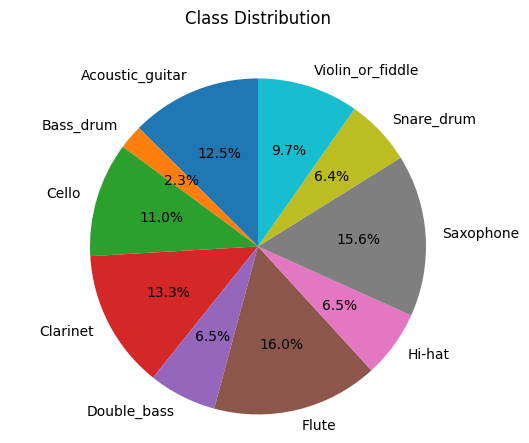

In [6]:
#Model Preparation
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    # Calculate the duration of the audio file and add it to the dataframe.
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label)) # Extract classes from the dataframe.
class_dist = df.groupby(['label'])['length'].mean() # Compute the average duration of audio files per class.

# Determine the total number of samples to generate, based on the sum of audio lengths and a chosen time frame (0.1 seconds here).
n_samples = 2 * int(df['length'].sum()/0.1) 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

## Data Checking Function

The `check_data` function serves as a utility to verify the presence of preprocessed data, which is crucial for optimizing the workflow in machine learning projects. 

In [7]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

## Feature Building Function

The `build_rand_feat` function is a key component of the audio processing pipeline. It constructs the feature set for the machine learning model by extracting Mel Frequency Cepstral Coefficients (MFCCs) from the audio files. This function either loads preprocessed data if available or processes raw audio files to generate features.

In [8]:
def build_rand_feat() :
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        # Extract MFCC features from the audio sample.
        X_sample = mfcc(sample ,rate ,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    # Normalize the features to be within the range [0, 1].
    X = (X - _min) / (_max - _min)

    # Reshape the feature array based on the model type.
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X,y)

    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    return X, y

In [36]:
def setup_model(config):
    # Build features and labels
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Determine the input shape based on the mode
    if config.mode == 'conv':
        input_shape = (X.shape[1], X.shape[2], 1)
        model = get_conv_model(input_shape)
    elif config.mode == 'time':
        input_shape = (X.shape[1], X.shape[2])
        model = get_recurrent_model(input_shape)
    else:
        raise ValueError("Mode should be either 'conv' or 'time'")

    return X_train, X_test, y_train, y_test, model

def train_model(X_train, y_train, model, config):
    y_flat = np.argmax(y_train, axis=1)
    class_weights = compute_class_weights(y_flat)

    checkpoint = ModelCheckpoint(
        config.model_path, monitor='val_acc', verbose=0,
        mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch'
    )
    
    history = model.fit(
        X_train, y_train, epochs=30, batch_size=32, shuffle=True,
        validation_split=0.2, class_weight=class_weights, callbacks=[checkpoint]
    )
    
    model.save(config.model_path)

    return history
    
from collections import Counter
def compute_class_weights(y_flat):
    class_counts = Counter(y_flat)
    total_samples = len(y_flat)
    return {class_label: total_samples / class_count for class_label, class_count in class_counts.items()}


In [37]:
config = Config(mode='conv')  
X_train, X_test, y_train, y_test, model = setup_model(config)
history = train_model(X_train, y_train, model, config)

Loading existing data for conv model
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 13, 9, 16)         160       
                                                                 
 conv2d_33 (Conv2D)          (None, 13, 9, 32)         4640      
                                                                 
 conv2d_34 (Conv2D)          (None, 13, 9, 64)         18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 9, 128)        73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 6, 4, 128)         0         
                 

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 13s 26ms/step - loss: 12.7089 - acc: 0.5238 - val_loss: 0.8069 - val_acc: 0.7165
Epoch 2/30
460/463 [============================>.] - ETA: 0s - loss: 6.9093 - acc: 0.7395

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 12s 27ms/step - loss: 6.9060 - acc: 0.7392 - val_loss: 0.6142 - val_acc: 0.7839
Epoch 3/30
461/463 [============================>.] - ETA: 0s - loss: 4.7739 - acc: 0.8185

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 23s 49ms/step - loss: 4.7753 - acc: 0.8185 - val_loss: 0.4344 - val_acc: 0.8542
Epoch 4/30
462/463 [============================>.] - ETA: 0s - loss: 3.9073 - acc: 0.8519

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 21s 46ms/step - loss: 3.9074 - acc: 0.8519 - val_loss: 0.3682 - val_acc: 0.8796
Epoch 5/30
460/463 [============================>.] - ETA: 0s - loss: 3.2814 - acc: 0.8754

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 12s 25ms/step - loss: 3.2774 - acc: 0.8756 - val_loss: 0.3208 - val_acc: 0.8923
Epoch 6/30
463/463 [==============================] - 12s 25ms/step - loss: 2.9023 - acc: 0.8905 - val_loss: 0.3009 - val_acc: 0.8910
Epoch 7/30
461/463 [============================>.] - ETA: 0s - loss: 2.7079 - acc: 0.8978

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 12s 26ms/step - loss: 2.7088 - acc: 0.8977 - val_loss: 0.2700 - val_acc: 0.9086
Epoch 8/30
463/463 [==============================] - 10s 23ms/step - loss: 2.4041 - acc: 0.9085 - val_loss: 0.2838 - val_acc: 0.9015
Epoch 9/30
461/463 [============================>.] - ETA: 0s - loss: 2.1378 - acc: 0.9193

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 12s 26ms/step - loss: 2.1349 - acc: 0.9195 - val_loss: 0.2305 - val_acc: 0.9224
Epoch 10/30
463/463 [==============================] - 10s 23ms/step - loss: 1.9198 - acc: 0.9271 - val_loss: 0.2782 - val_acc: 0.9094
Epoch 11/30
462/463 [============================>.] - ETA: 0s - loss: 1.7594 - acc: 0.9326

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 13s 27ms/step - loss: 1.7596 - acc: 0.9326 - val_loss: 0.1922 - val_acc: 0.9391
Epoch 12/30
463/463 [==============================] - 10s 21ms/step - loss: 1.7078 - acc: 0.9339 - val_loss: 0.2461 - val_acc: 0.9207
Epoch 13/30
463/463 [==============================] - 11s 23ms/step - loss: 1.5872 - acc: 0.9391 - val_loss: 0.1981 - val_acc: 0.9391
Epoch 14/30
461/463 [============================>.] - ETA: 0s - loss: 1.3965 - acc: 0.9444

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 11s 23ms/step - loss: 1.3959 - acc: 0.9444 - val_loss: 0.1864 - val_acc: 0.9400
Epoch 15/30
461/463 [============================>.] - ETA: 0s - loss: 1.3416 - acc: 0.9463

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 11s 25ms/step - loss: 1.3392 - acc: 0.9464 - val_loss: 0.1862 - val_acc: 0.9424
Epoch 16/30
463/463 [==============================] - 12s 25ms/step - loss: 1.3872 - acc: 0.9500 - val_loss: 0.2530 - val_acc: 0.9237
Epoch 17/30
463/463 [==============================] - 13s 28ms/step - loss: 1.3344 - acc: 0.9495 - val_loss: 0.2037 - val_acc: 0.9359
Epoch 18/30
462/463 [============================>.] - ETA: 0s - loss: 1.1977 - acc: 0.9544

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 14s 30ms/step - loss: 1.1976 - acc: 0.9544 - val_loss: 0.1919 - val_acc: 0.9473
Epoch 19/30
463/463 [==============================] - 11s 24ms/step - loss: 1.0985 - acc: 0.9583 - val_loss: 0.1983 - val_acc: 0.9437
Epoch 20/30
463/463 [==============================] - 12s 26ms/step - loss: 1.3486 - acc: 0.9501 - val_loss: 0.1925 - val_acc: 0.9437
Epoch 21/30
462/463 [============================>.] - ETA: 0s - loss: 1.0979 - acc: 0.9606

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 13s 29ms/step - loss: 1.0978 - acc: 0.9606 - val_loss: 0.1743 - val_acc: 0.9483
Epoch 22/30
463/463 [==============================] - 11s 25ms/step - loss: 0.8262 - acc: 0.9690 - val_loss: 0.1921 - val_acc: 0.9481
Epoch 23/30
460/463 [============================>.] - ETA: 0s - loss: 0.9880 - acc: 0.9623

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


463/463 [==============================] - 14s 30ms/step - loss: 0.9878 - acc: 0.9622 - val_loss: 0.1550 - val_acc: 0.9567
Epoch 24/30
463/463 [==============================] - 12s 25ms/step - loss: 1.0266 - acc: 0.9624 - val_loss: 0.1888 - val_acc: 0.9462
Epoch 25/30
463/463 [==============================] - 12s 25ms/step - loss: 0.7433 - acc: 0.9713 - val_loss: 0.1689 - val_acc: 0.9532
Epoch 26/30
463/463 [==============================] - 12s 25ms/step - loss: 0.8896 - acc: 0.9667 - val_loss: 0.2012 - val_acc: 0.9478
Epoch 27/30
463/463 [==============================] - 11s 23ms/step - loss: 0.8521 - acc: 0.9669 - val_loss: 0.1755 - val_acc: 0.9540
Epoch 28/30
463/463 [==============================] - 12s 25ms/step - loss: 0.6851 - acc: 0.9749 - val_loss: 0.1910 - val_acc: 0.9483
Epoch 29/30
463/463 [==============================] - 10s 22ms/step - loss: 0.9517 - acc: 0.9650 - val_loss: 0.1824 - val_acc: 0.9502
Epoch 30/30
463/463 [==============================] - 11s 24ms/ste

INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


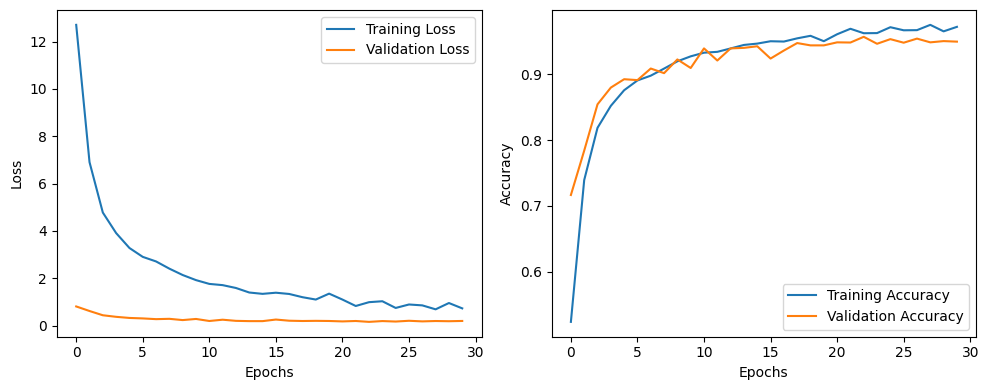

In [40]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.1617
Test Accuracy: 0.9543


### LSTM TRAINING

In [41]:
config = Config(mode='time')  
X_train, X_test, y_train, y_test, model = setup_model(config)
history = train_model(X_train, y_train, model, config)

Loading existing data for time model
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 128)           70656     
                                                                 
 lstm_1 (LSTM)               (None, 13, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 13, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 13, 64)           8256      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 13, 32)           2080      
 tributed)                                                       
                                                                 
 time_distributed

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 19s 34ms/step - loss: 23.0316 - acc: 0.0929 - val_loss: 2.3037 - val_acc: 0.1136
Epoch 2/30
460/463 [============================>.] - ETA: 0s - loss: 20.9682 - acc: 0.1567

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 15s 32ms/step - loss: 20.9573 - acc: 0.1578 - val_loss: 1.7638 - val_acc: 0.3186
Epoch 3/30
463/463 [==============================] - ETA: 0s - loss: 14.3032 - acc: 0.4349

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 16s 35ms/step - loss: 14.3032 - acc: 0.4349 - val_loss: 1.3663 - val_acc: 0.4947
Epoch 4/30
461/463 [============================>.] - ETA: 0s - loss: 12.0545 - acc: 0.5304

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 16s 36ms/step - loss: 12.0533 - acc: 0.5304 - val_loss: 1.2167 - val_acc: 0.5807
Epoch 5/30
463/463 [==============================] - 13s 28ms/step - loss: 11.0643 - acc: 0.5687 - val_loss: 1.4586 - val_acc: 0.4612
Epoch 6/30
460/463 [============================>.] - ETA: 0s - loss: 10.7226 - acc: 0.5840

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 19s 41ms/step - loss: 10.7202 - acc: 0.5842 - val_loss: 1.0790 - val_acc: 0.6164
Epoch 7/30
462/463 [============================>.] - ETA: 0s - loss: 10.0215 - acc: 0.6127

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 19s 40ms/step - loss: 10.0219 - acc: 0.6126 - val_loss: 1.0570 - val_acc: 0.6308
Epoch 8/30
463/463 [==============================] - 13s 28ms/step - loss: 9.6314 - acc: 0.6281 - val_loss: 1.0460 - val_acc: 0.6259
Epoch 9/30
461/463 [============================>.] - ETA: 0s - loss: 9.0339 - acc: 0.6535

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 19s 41ms/step - loss: 9.0352 - acc: 0.6535 - val_loss: 1.0094 - val_acc: 0.6311
Epoch 10/30
463/463 [==============================] - 15s 32ms/step - loss: 8.6475 - acc: 0.6643 - val_loss: 1.3505 - val_acc: 0.5299
Epoch 11/30
462/463 [============================>.] - ETA: 0s - loss: 8.7323 - acc: 0.6646

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 21s 44ms/step - loss: 8.7319 - acc: 0.6647 - val_loss: 0.9479 - val_acc: 0.6708
Epoch 12/30
462/463 [============================>.] - ETA: 0s - loss: 7.9029 - acc: 0.6963

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 21s 44ms/step - loss: 7.9029 - acc: 0.6962 - val_loss: 0.8100 - val_acc: 0.7241
Epoch 13/30
463/463 [==============================] - 14s 31ms/step - loss: 7.5543 - acc: 0.7071 - val_loss: 0.8749 - val_acc: 0.7060
Epoch 14/30
462/463 [============================>.] - ETA: 0s - loss: 7.2888 - acc: 0.7230

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 20s 43ms/step - loss: 7.2902 - acc: 0.7230 - val_loss: 0.7692 - val_acc: 0.7349
Epoch 15/30
461/463 [============================>.] - ETA: 0s - loss: 6.9200 - acc: 0.7385

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 24s 52ms/step - loss: 6.9131 - acc: 0.7389 - val_loss: 0.7257 - val_acc: 0.7539
Epoch 16/30
463/463 [==============================] - 14s 31ms/step - loss: 6.7034 - acc: 0.7456 - val_loss: 0.7771 - val_acc: 0.7325
Epoch 17/30
463/463 [==============================] - 14s 30ms/step - loss: 6.5749 - acc: 0.7510 - val_loss: 0.7301 - val_acc: 0.7498
Epoch 18/30
462/463 [============================>.] - ETA: 0s - loss: 6.5117 - acc: 0.7512

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 29s 62ms/step - loss: 6.5114 - acc: 0.7512 - val_loss: 0.6325 - val_acc: 0.7901
Epoch 19/30
463/463 [==============================] - 15s 33ms/step - loss: 5.8805 - acc: 0.7744 - val_loss: 0.6740 - val_acc: 0.7625
Epoch 20/30
463/463 [==============================] - 14s 31ms/step - loss: 5.7167 - acc: 0.7833 - val_loss: 0.7080 - val_acc: 0.7639
Epoch 21/30
462/463 [============================>.] - ETA: 0s - loss: 5.6296 - acc: 0.7853

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 22s 47ms/step - loss: 5.6292 - acc: 0.7853 - val_loss: 0.5989 - val_acc: 0.7931
Epoch 22/30
463/463 [==============================] - ETA: 0s - loss: 5.4149 - acc: 0.7923

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 35s 75ms/step - loss: 5.4149 - acc: 0.7923 - val_loss: 0.5583 - val_acc: 0.8153
Epoch 23/30
463/463 [==============================] - ETA: 0s - loss: 5.1283 - acc: 0.8026

INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


463/463 [==============================] - 35s 75ms/step - loss: 5.1283 - acc: 0.8026 - val_loss: 0.5032 - val_acc: 0.8323
Epoch 24/30
463/463 [==============================] - 16s 34ms/step - loss: 5.0272 - acc: 0.8088 - val_loss: 0.5505 - val_acc: 0.8088
Epoch 25/30
463/463 [==============================] - 19s 41ms/step - loss: 4.7103 - acc: 0.8178 - val_loss: 0.5299 - val_acc: 0.8166
Epoch 26/30
463/463 [==============================] - 25s 54ms/step - loss: 4.5252 - acc: 0.8261 - val_loss: 0.4898 - val_acc: 0.8280
Epoch 27/30
463/463 [==============================] - ETA: 0s - loss: 4.5224 - acc: 0.8233

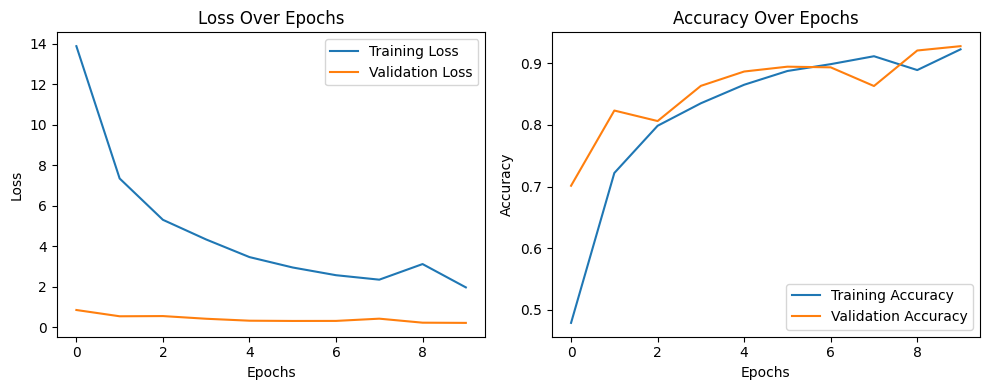

In [34]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2073
Test Accuracy: 0.9328
